# Morgan FP, SMC, Random forest & Neural Network
In this document, we calculated Morgan Fingerprint for each reaction in Buckwald-Hartwig dataset, and then train them use Random forest & neural network.

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem import AllChem, MolFromSmiles
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import DataStructs
from rdkit import Chem

c:\Users\Ran Tao\.conda\envs\edbo\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['Cl', 'C', '1', '=', 'C', 'C', '=', 'C', '(', 'O', 'C', ')', 'C', '=', 'C', '1', '.', 'O', 'B', '(', 'O', ')', 'C', '1', '=', 'C', 'C', '=', 'C', 'C', '=', 'C', '1', '>>', 'C', 'O', 'C', '(', 'C', '=', 'C', '1', ')', '=', 'C', 'C', '=', 'C', '1', 'C', '2', '=', 'C', 'C', '=', 'C', 'C', '=', 'C', '2']


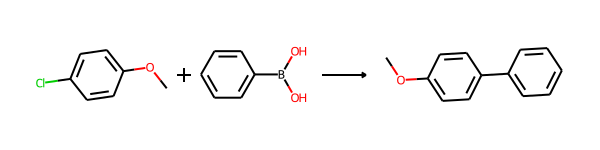

In [2]:
from rxnfp.tokenization import get_default_tokenizer, SmilesTokenizer
from rdkit.Chem import rdChemReactions

smiles_tokenizer = get_default_tokenizer()

reaction_smiles = 'ClC1=CC=C(OC)C=C1.OB(O)C1=CC=CC=C1>>COC(C=C1)=CC=C1C2=CC=CC=C2'
rxn = rdChemReactions.ReactionFromSmarts(reaction_smiles,useSmiles=True)

print(smiles_tokenizer.tokenize(reaction_smiles))
rxn

In [3]:
"""
   reference codes
   """
# export
def canonicalize_with_dict(smi, can_smi_dict={}):
    if smi not in can_smi_dict.keys():
        return Chem.MolToSmiles(Chem.MolFromSmiles(smi))
    else:
        return can_smi_dict[smi]

def generate_buchwald_hartwig_rxns(df):
    """
    Converts the entries in the excel files from Sandfort et al. to reaction SMILES.
    """
    df = df.copy()
    fwd_template = '[F,Cl,Br,I]-[c;H0;D3;+0:1](:[c,n:2]):[c,n:3].[NH2;D1;+0:4]-[c:5]>>[c,n:2]:[c;H0;D3;+0:1](:[c,n:3])-[NH;D2;+0:4]-[c:5]'
    methylaniline = 'Cc1ccc(N)cc1'
    pd_catalyst = Chem.MolToSmiles(Chem.MolFromSmiles('O=S(=O)(O[Pd]1~[NH2]C2C=CC=CC=2C2C=CC=CC1=2)C(F)(F)F'))
    methylaniline_mol = Chem.MolFromSmiles(methylaniline)
    rxn = rdChemReactions.ReactionFromSmarts(fwd_template)
    products = []
    for i, row in df.iterrows():
        reacts = (Chem.MolFromSmiles(row['Aryl halide']), methylaniline_mol)
        rxn_products = rxn.RunReactants(reacts)

        rxn_products_smiles = set([Chem.MolToSmiles(mol[0]) for mol in rxn_products])
        assert len(rxn_products_smiles) == 1
        products.append(list(rxn_products_smiles)[0])
    df['product'] = products
    rxns = []
    can_smiles_dict = {}
    for i, row in df.iterrows():
        aryl_halide = canonicalize_with_dict(row['Aryl halide'], can_smiles_dict)
        can_smiles_dict[row['Aryl halide']] = aryl_halide
        ligand = canonicalize_with_dict(row['Ligand'], can_smiles_dict)
        can_smiles_dict[row['Ligand']] = ligand
        base = canonicalize_with_dict(row['Base'], can_smiles_dict)
        can_smiles_dict[row['Base']] = base
        additive = canonicalize_with_dict(row['Additive'], can_smiles_dict)
        can_smiles_dict[row['Additive']] = additive
        
        reactants = f"{aryl_halide}.{methylaniline}.{pd_catalyst}.{ligand}.{base}.{additive}"
        rxns.append(f"{reactants}.{row['product']}")
    return rxns

In [4]:
""""
def canonicalize_with_dict(smi, can_smi_dict={}):
    if smi not in can_smi_dict.keys():
        return Chem.MolToSmiles(Chem.MolFromSmiles(smi))
    else:
        return can_smi_dict[smi]
"""
    
def generate_ligand_data(df):
    #Convert the smiles of ligand to a dataframe.
    df = df.copy()
    
    #ligand_smiles_dict = {}
    rxns = []
    """
    The rxns is not useful now. When we use the whole rxn instead of ligand to predict, it will be convenient.
    To try with the entire rxn, tabulate all chemicals into a single column of dataframe.
    """
    smiles = df['Smiles']
    for i in smiles:
        try:
            ligand_smiles = Chem.MolFromSmiles(i)
            rxns.append(ligand_smiles)
        except:
            print(i)
        
    return rxns
   

# Cleaning up the SMC dataset
Train set: 0-71, validation set: 71-81, test set: 81-all

In [5]:
# data
import pandas as pd
from rdkit import Chem
#from rxn_yields.data import generate_buchwald_hartwig_rxns
#df = pd.read_excel('../data/Buchwald-Hartwig/Dreher_and_Doyle_input_data.xlsx', sheet_name='FullCV_01')
df = pd.read_excel('smc_data.xlsx', sheet_name='SMC')
df['rxn'] = df['Smiles']
df['ligand_data'] = generate_ligand_data(df)
df['Output'] = df['III']

train_df = df.iloc[:71][['rxn', 'Output']] 
valid_df = df.iloc[71:81][['rxn', 'Output']] 
test_df = df.iloc[81:][['rxn', 'Output']] #

train_df.columns = ['text', 'labels']
valid_df.columns = ['text', 'labels']
test_df.columns = ['text', 'labels']
mean = train_df.labels.mean()
std = train_df.labels.std()
train_df['labels'] = (train_df['labels'] - mean) / std
valid_df['labels'] = (valid_df['labels'] - mean) / std
test_df['labels'] = (test_df['labels'] - mean) / std
train_df.head()

,text,labels
0,CN(C)C(C=CC=C1N(C)C)=C1C2=CC=CC=C2P(C3CCCCC3)C...,-0.694908
1,C1CCC(CC1)P(C2CCCCC2)c3ccccc3-c4ccccc4,-0.512399
2,C1C2CC3CC1CC(P(C14CC5CC(CC(C5)C1)C4)C14CC5CC(C...,-0.694908
3,CC(C)(C)P(C(C)(C)C)C(C)(C)C,-0.694908
4,CCCCP(C12CC3CC(CC(C3)C1)C2)C12CC3CC(CC(C3)C1)C2,-0.451562


In [6]:
train_df['text'][1]

'C1CCC(CC1)P(C2CCCCC2)c3ccccc3-c4ccccc4'

In [7]:
x=MolFromSmiles("c1ccc(P(C2CCCCC2)C2CCCCC2)cc1")
x = AllChem.GetMorganFingerprintAsBitVect(x,2,nBits=1024)
arr = np.zeros((1,))
DataStructs.ConvertToNumpyArray(x, arr)

x

In [8]:
remover = SaltRemover(defnData="[Cl,Br]")
morgan_list, mol_list_none = [], []
mol_list = []

for i,smiles in enumerate(train_df['text']):
    d1 = MolFromSmiles(smiles)
    if d1 is None:
        mol_list_none.append(i)
    else:
        d2 = remover.StripMol(d1)
        mol_list.append(d2)
        f1 = AllChem.GetMorganFingerprintAsBitVect(d2,2,nBits=1024)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f1, arr)
#         print(arr)
        if any(np.isnan(arr)):
            mol_list_none.append(i)
        else:
            morgan_list.append(arr)
            
train_df = train_df.drop(mol_list_none)
train_df["morgan_fingerprints"] = morgan_list
train_df = train_df.reset_index()

train_df.head()

,index,text,labels,morgan_fingerprints
0,0,CN(C)C(C=CC=C1N(C)C)=C1C2=CC=CC=C2P(C3CCCCC3)C...,-0.694908,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,C1CCC(CC1)P(C2CCCCC2)c3ccccc3-c4ccccc4,-0.512399,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,C1C2CC3CC1CC(P(C14CC5CC(CC(C5)C1)C4)C14CC5CC(C...,-0.694908,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,CC(C)(C)P(C(C)(C)C)C(C)(C)C,-0.694908,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,CCCCP(C12CC3CC(CC(C3)C1)C2)C12CC3CC(CC(C3)C1)C2,-0.451562,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
remover = SaltRemover(defnData="[Cl,Br]")
morgan_list, mol_list_none = [], []
mol_list = []

for i,smiles in enumerate(valid_df['text']):
    d1 = MolFromSmiles(smiles)
    if d1 is None:
        mol_list_none.append(i)
    else:
        d2 = remover.StripMol(d1)
        mol_list.append(d2)
        f1 = AllChem.GetMorganFingerprintAsBitVect(d2,2,nBits=1024)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f1, arr)
#         print(arr)
        if any(np.isnan(arr)):
            mol_list_none.append(i)
        else:
            morgan_list.append(arr)
            
valid_df = valid_df.drop(mol_list_none)
valid_df["morgan_fingerprints"] = morgan_list
valid_df = valid_df.reset_index()

valid_df.head()

,index,text,labels,morgan_fingerprints
0,71,COc1cc(OC)c(c(OC)c1)-c2ccccc2P(C3CCCCC3)C4CCCCC4,-0.634072,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,72,CC(C)(C)P(c1ccnn1-c1cccc2ccccc12)C(C)(C)C,-0.694908,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,73,C1CCC(CC1)P(C2CCCCC2)c3ccnn3-c4c(nn(-c5ccccc5)...,-0.694908,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,74,c1ccc(P(C2CCCCC2)C2CCCCC2)c(-n2c3ccccc3c3ccccc...,-0.694908,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,75,C1[C@@H]2C[C@@H]3C[C@H]1C[C@](C2)(C3)P(c4ccnn4...,-0.694908,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [10]:
remover = SaltRemover(defnData="[Cl,Br]")
morgan_list, mol_list_none = [], []
mol_list = []

for i,smiles in enumerate(test_df['text']):
    d1 = MolFromSmiles(smiles)
    if d1 is None:
        mol_list_none.append(i)
    else:
        d2 = remover.StripMol(d1)
        mol_list.append(d2)
        f1 = AllChem.GetMorganFingerprintAsBitVect(d2,2,nBits=1024)
        arr = np.zeros((1,))
        DataStructs.ConvertToNumpyArray(f1, arr)
#         print(arr)
        if any(np.isnan(arr)):
            mol_list_none.append(i)
        else:
            morgan_list.append(arr)
            
test_df = test_df.drop(mol_list_none)
test_df["morgan_fingerprints"] = morgan_list
test_df = test_df.reset_index()

test_df.head()

,index,text,labels,morgan_fingerprints
0,81,N#Cc1ccccc1P(c1ccccc1)c1ccccc1,-0.694908,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,82,COC(=O)CCP(CCC(=O)OC)CCC(=O)OC,-0.694908,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,83,OCP(CO)CO,-0.694908,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,84,O=C(O)c1cccc(P(c2cccc(C(F)(F)F)c2)c2cccc(C(F)(...,-0.694908,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,85,O=C(O)c1cccc(P(c2cccc(C(=O)O)c2)c2cccc(C(F)(F)...,-0.694908,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [11]:
X_train = train_df['morgan_fingerprints'].tolist()
y_train = train_df['labels'].tolist()

X_test = test_df['morgan_fingerprints'].tolist()
y_test = test_df['labels'].tolist()


In [12]:
print(y_train[0], type(y_train[0]))
print(len(X_train))

-0.6949084536087448 <class 'float'>
71


# Random Forest Model

In [13]:
from sklearn.ensemble import RandomForestRegressor

RF_clf = RandomForestRegressor(max_features=0.8,min_impurity_decrease=0,min_samples_leaf=1,n_estimators=500)
RF_clf.fit(X_train, y_train)

RandomForestRegressor(max_features=0.8, min_impurity_decrease=0,
                      n_estimators=500)

In [14]:
from sklearn.metrics import mean_squared_error
forest_predictions = RF_clf.predict(X_train)
forest_mse = mean_squared_error(y_train, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
print("Training set RMSE:",forest_rmse)

forest_predictions2 = RF_clf.predict(X_test)
forest_mse2 = mean_squared_error(y_test, forest_predictions2)
forest_rmse2 = np.sqrt(forest_mse2)
print("Test set RMSE:",forest_rmse2)


Training set RMSE: 0.317740026125415
Test set RMSE: 0.533916526091164


In [15]:
from sklearn.metrics import r2_score
r2_score2=r2_score(y_train, forest_predictions)
print("Training set R^2:",r2_score2)
r2_score3=r2_score(y_test, forest_predictions2)
print("Test set R^2:",r2_score3)

Training set R^2: 0.897599008309218
Test set R^2: 0.0


In [16]:
y_test_plot=[]
for i in y_test:
    x=i*std+mean
    y_test_plot.append(x)

In [17]:
forest_plot=[]
for i in forest_predictions2:
    x=i*std+mean
    forest_plot.append(x)

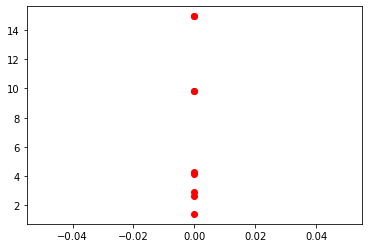

In [18]:
import matplotlib.pyplot as plt

plt.plot(y_test_plot,forest_plot, 'ro')

plt.show()

In [19]:
forest_mse4 = mean_squared_error(y_test_plot, forest_plot)
forest_rmse4 = np.sqrt(forest_mse4)
print("Test set RMSE:",forest_rmse4)

Test set RMSE: 8.776235614177386


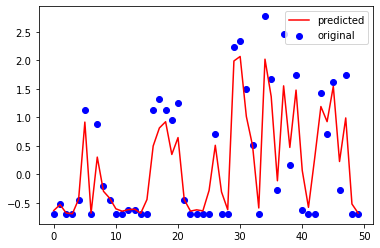

In [20]:
x = list(range(len(y_train)))

plt.scatter(x[0:50], y_train[0:50], color="blue", label="original")
plt.plot(x[0:50], forest_predictions[0:50], color="red", label="predicted")
plt.legend()

plt.show()

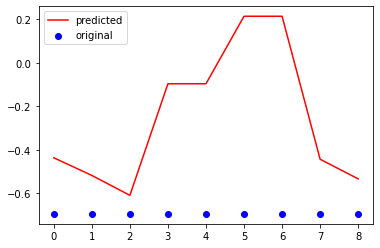

In [21]:
x = list(range(len(y_test)))

plt.scatter(x[0:50], y_test[0:50], color="blue", label="original")
plt.plot(x[0:50], forest_predictions2[0:50], color="red", label="predicted")
plt.legend()

plt.show()


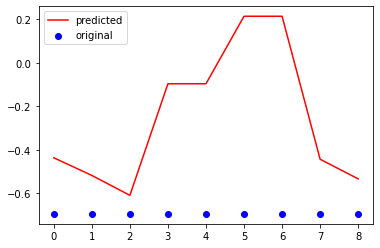

In [22]:
x = list(range(len(y_test)))

plt.scatter(x[0:len(y_test)], y_test[0:len(y_test)], color="blue", label="original")
plt.plot(x[0:len(y_test)], forest_predictions2[0:len(y_test)], color="red", label="predicted")
plt.legend()

plt.show()


In [23]:
print(type(X_train[0][0]), X_train[0][2])

<class 'numpy.float64'> 1.0


# Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X, y)

NameError: name 'X' is not defined

# RNN model

In [ ]:
import torch.nn.functional as F
import torch.nn as nn
class Model(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size=1024, hidden_size=2048, out_size=1, n_hidden=0, activation=F.relu, bn=False,
                **kwargs):
        super().__init__()
        self.bn = bn
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.hiddens = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(n_hidden)])
        self.bn_hiddens = nn.ModuleList([nn.BatchNorm1d(hidden_size) for i in range(n_hidden)])
        self.bn = nn.BatchNorm1d(hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        self.activation = activation
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        for l, bn in zip(self.hiddens, self.bn_hiddens):
            if self.bn:
                out = bn(out)
            out = self.activation(out)
            out = l(out)
        # Apply activation function
        if self.bn:
            out = self.bn(out)
        out = self.activation(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out.view(-1)   
    
    def training_step(self, batch):
        images, labels = batch 
        #print(images.dtype, labels.dtype)
        out = self(images).view(-1)  
        #print(out.dtype)# Generate predictions
        loss = F.mse_loss(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images).view(-1)                       # Generate predictions
        loss = F.mse_loss(out, labels)   # Calculate loss           # Calculate accuracy
        return {'val_loss': loss}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
#         batch_accs = [x['val_acc'] for x in outputs]
#         epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['train_loss'], result['val_loss']))

In [ ]:
default_nn = Model()

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

NameError: name 'torch' is not defined

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

x_train, y_train, x_valid, y_valid, x_test, y_test = map(
    torch.tensor, (X_train, y_train, x_valid, y_valid, X_test, y_test)
)


training_data = TensorDataset(x_train.to(torch.float32), y_train)
validation_data = TensorDataset(x_valid.to(torch.float32), y_valid)
test_data = TensorDataset(x_test.to(torch.float32), y_test)

batch_size = 128

# Create data loaders.
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validation_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_loader:
    print("Shape of X [N, C]: ", X.shape,X.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break

NameError: name 'x_valid' is not defined

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
for X, y in train_loader:
    print("Shape of X [N, C]: ", X.shape,X.dtype)
    print("Shape of y: ", y.shape, y.dtype)
    break

In [ ]:
import copy
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5)
    best_loss = np.inf
    best_model = None
    for epoch in range(epochs):
        # Training Phase 
        train_loss = 0.
        train_count = 0
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()*len(batch)
            train_count += len(batch)
        train_loss /= train_count
        # Validation phase
        result = evaluate(model, val_loader)
        result["train_loss"] = train_loss
        scheduler.step(result["val_loss"])
        
        if result["val_loss"] < best_loss:
            best_model = copy.deepcopy(model)
        
        if epoch%20 == 0:
            model.epoch_end(epoch, result)
        history.append(result)
    return history, best_model

In [ ]:
default_nn = default_nn

In [ ]:
default_nn = Model().to(device)
history, best_model = fit(150, 0.0005, default_nn, train_loader, valid_loader)

In [ ]:
from sklearn.metrics import mean_squared_error
print("train RMSE: ", mean_squared_error(y_train.cpu(), best_model(to_device(x_train.to(torch.float32), device)).cpu().detach().numpy()))
print("test RMSE: ", mean_squared_error(y_test.cpu(), best_model(to_device(x_test.to(torch.float32), device)).cpu().detach().numpy()))

In [ ]:
from sklearn.metrics import r2_score
r2_score5=r2_score(y_train.cpu(), best_model(to_device(x_train.to(torch.float32), device)).cpu().detach().numpy())
print("Training set R^2:",r2_score5)
r2_score6=r2_score(y_test.cpu(), best_model(to_device(x_test.to(torch.float32), device)).cpu().detach().numpy())
print("test set R^2:",r2_score6)

In [ ]:
def train_curve(history):
    for key in ["train_loss", "val_loss"]:
        plt.plot([history_[key] for history_ in history], label=key)
    plt.xlabel("epoch")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

In [ ]:
train_curve(history)

# Summary
#### Random Forest:
Training set RMSE: 0.0979

Test set RMSE: 0.269

Training set R^2: 0.990

Test set R^2: 0.930


#### Neural Network:
Training set RMSE: 0.0895

Test set RMSE: 0.136

Training set R^2: 0.911

Test set R^2: 0.868